# Atividade 05: Usando o *Framework* Tensorflow

*Complete e entregue toda essa atividade (incluindo suas saídas e qualquer código adicional que você desenvolva) juntamente com a submissão de seu trabalho prático. Maiores detalhes podem ser vistos na página da disciplina.*

## Sobre TensorFlow

Até o presente momento, você escreveu bastante código de forma a implementar as funcionalidades de uma rede neural. Técnicas como *dropout*, *batch normalization* e *convoluções* são essenciais para o aprendizado de redes profundas (especialmente em visão computational). você também trabalhou bastante de forma a tornar suas implementações eficientes.

Nesta última parte, você irá deixar um pouco de lado a codificação de sua própria implementação (por mais "belo" que seja) e, em seu lugar, migrar para a utilização de um dos mais populares *frameworks* para *deep learning*: **Tensorflow**. 

#### O que é o *Tensorflow* na realidade?
TensorFlow representa um sistema para execução de grafos de computação sobre tensores (entidades matemáticas usadas para generalizar a noção de escalar, vetor e matriz). Além disso, ele possui suporte para realizar *backpropagation* sobre variáveis. Nele, será possível trabalhar com tensores que representam vetores *n*-dimensionais análogos aos vetores de *numpy*.

#### Por que usar *Tensorflow*?

* Seu código agora irá facilmente ser executado em GPUs! Dessa forma, você conseguirá realizar treinamento de forma mais rápida. Infelizmente, a escrita de seu próprio código para execução em GPUs está fora do escopo dessa disciplina.
* Deseja-se prepará-lo para utilizar um dos *frameworks* disponíveis na atualidade em seus projetos de modo que você possa realizar experimentos de forma mais eficiente do que se tivesse que escrever "do zero" cada técnica e facilidade que desejasse usar.
* Deseja-se colocar você em contato com o tipo de implementação de *deep learning* que provavelmente você irá se deparar tanto na academia quanto na indústria.


## Como você pode aprender sobre *TensorFlow*?

Existem inúmeros tutoriais de excelente qualidade para o *Tensorflow* disponíveis na Web, incluindo aqueles disponibilizados pela própria 
[Google](https://www.tensorflow.org/get_started).


Além disso, este *notebook* irá guiá-lo sobre os proncipais passos necessários para você realizar treinamento de modelos no *Tensorflow*. No final desse *notebook*, você encontrará alguns *links* para outros tutoriais que você poderá utilizar para aprender mais ou caso deseje maiores esclarecimentos sobre tópicos que não sejam explicados de forma completa aqui.


## Carregar Conjuntos de Dados


In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get -qq install -y software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get -qq update 2>&1 > /dev/null
!apt-get -y -qq install google-drive-ocamlfuse fuse
print('Instalado!')

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Preparing to unpack .../04-gnupg_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg (2.1.15-1ubuntu8.1) over (2.1.15-1ubuntu8) ...
Preparing to unpack .../05-gnupg-agent_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg-agent (2.1.15-1ubuntu8

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [3]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [4]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

#print 'Files in Drive:'
!ls drive/"Colab Notebooks"/i2dl/tp2/dl/datasets/"cifar-10-batches-py"/

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [0]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import sys
import os
PATH_DIRECTORY = 'drive/Colab Notebooks/i2dl/tp2'
os.chdir(PATH_DIRECTORY)

In [8]:
from dl.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Carrega CIFAR-10 dataset a partit do disco e realiza preprocessamento para preparar
    os dados para o classificador linear. Estes são os mesmos passos usados para o modelo
    SVM, porém condensado em uma única função.  
    """
    # Carregga os dados CIFAR-10 brutos
    cifar10_dir = 'dl/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subdivide os dados em conjuntos
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normaliza os dados: subtrai a imagem média
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Usar a função definida acmina para obter os dados.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Modelo de Exemplo

Lembre-se de que o conjunto de imagens possui inicialment as seguintes dimensões $N \times H \times W \times C$ em que:
* $N$ representa o número de elementos ou imagens;
* $H$ é a altura de cada imagem em pixels;
* $W$ é a largura de cada imagem em pixels; e
* $C$ representa o número de canais (geralmente três: R, G e B).

Este á a forma correta de se representar os dados quando se está realizando algo como uma convolução 2D, que necessita compreender a relação espacial entre os pixels e seus vizinhos. Entretando, quando se fornece uma imagem de entrada a uma camada afim completamente conectada, deve-se optar por representar cada amostra (ou imagem) como um único vetor -- uma vez que não é útil se separar os diferentes canais, linhas e colunas dos dados.

### O modelo de exemplo propriamente dito

O primeiro passo para treinar seu próprio modelo é definir sua arquitetura.

Em seguida, você irá encontrar um exemplo de rede neural convolucional definada usando **Tensorflow** -- procure entender o que cada linha de código representa, lembrando-se de que cada camada é formada a partir da camada anterior. A princípio, não será realizado nenhum treinamento ainda (isso será feito em breve); por enquanto, vode deve se preocupar em compreender como a inicialização de cada elemento é realizada. 

Neste exemplo, você irá ver camadas convolucionais (Conv2d) ativações ReLU e camadas (lineares) completamente conectadas. Você também observará o uso da função de perda *hinge loss* e do método de otimização *Adam*.

Você deve ter certeza de que compreendeu as razões para as dimensões da camada linear serem 5408 e 10.

### Detalhes sobre *TensorFlow*
Quando se utiliza **Tensorflow**, semelhante ao *notebooks* anteriores, você deverá primeiramente inicializar suas variáveis e, em seguida, o modelo a ser utilizado.

In [0]:
# Limpa variáveis antigas
tf.reset_default_graph()

# Definir a entrada (p.ex. os dados que se alteram a cada 'minibatch')
# A primeira dimensão é 'None', e seu valor será obtido de forma automática a partir do tamanho do 'batch' utilizado
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # Definir os pesos (p.ex., inicializar uma rede convolucional de duas camadas)
    
    # Definir variáveis
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # Definir o grafo de computação (p.ex., uma rede convolucional de duas camadas)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# Definir a função de perda
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# Definir o método de otimização
optimizer = tf.train.AdamOptimizer(5e-4) # selecionar o 'otimizador' e ficar a taxa de aprendizado
train_step = optimizer.minimize(mean_loss)

**Tensorflow** dá suporte a vários outros tipos de camadas, funções de perda e otimizadores - você irá experimentar com alguns deles mais adiante. Você encontrará a documentação oficial da API do **Tensorflow** nos links abaixo (caso algum dos parâmetros usados acima não estejam claros, essas referências certamente serão úteis):

* [Camadas,  funções de ativação e de perda](https://www.tensorflow.org/api_guides/python/nn)
* [Otimizadores](https://www.tensorflow.org/api_guides/python/train#Optimizers)
* [*Batch normalization*](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization)

### Treinando o modelo por uma única época
Quando se define um grafo de operações como acima, de forma a executá-lo utilizando o **Tensorflow** fornecendo-se dados de entrada e calculando-se resultados, é necessário primeiramente que se crie uma instância/objeto da classe `tf.Session`.

Uma sessão encapsula o controle e estado de um ambiente de execução em **Tensorflow**. Para maiores informações, veja o tutorial sobre [Iniciando o Uso de Tensorflow](https://www.tensorflow.org/get_started/).

Opcionalmente, você pode também especificar *contexto de dispositivo* tal como `/cpu:0` ou `/gpu:0` de forma a determinar onde o cálculo deve ser realizado. Para documentação sobre essa facilidade veja o guia sobre [Usando GPU no TensorFlow](https://www.tensorflow.org/tutorials/using_gpu).

Você pode usar o código na próxima célula para treinar o modelo anterior por uma única época. Você deverá observar uma perda no conjunto de validação entre 0,4 e 0,6 e uma acurácia entre 0,30 e 0,38.

Training
Iteration 0: with minibatch training loss = 7.76 and accuracy of 0.16
Iteration 100: with minibatch training loss = 0.906 and accuracy of 0.22
Iteration 200: with minibatch training loss = 0.689 and accuracy of 0.3
Iteration 300: with minibatch training loss = 0.668 and accuracy of 0.28
Iteration 400: with minibatch training loss = 0.526 and accuracy of 0.38
Iteration 500: with minibatch training loss = 0.475 and accuracy of 0.38
Iteration 600: with minibatch training loss = 0.432 and accuracy of 0.44
Iteration 700: with minibatch training loss = 0.459 and accuracy of 0.41
Epoch 1, Overall loss = 0.744 and accuracy of 0.315


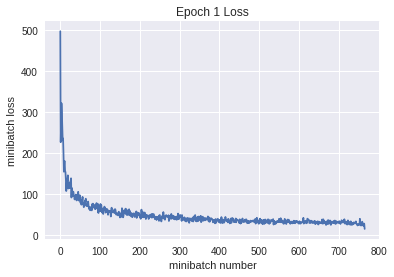

Validation
Epoch 1, Overall loss = 0.45 and accuracy of 0.382


In [10]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # Prepara o Tensorflow para o calculo da acurácia
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Embaralha os índices dos dados
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # Define-se as variáveis que se deseja calcular (e otimizar)
    # se houver uma função para treinamente, ela é adicionada ao 
    # conjunto de elementos a ser computar
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # Inicializa contador de iterações 
    iter_cnt = 0
    for e in range(epochs):
        # Inicialização para se armazenar os valores de perda e acurácia 
        correct = 0
        losses = []
        # Realiza-se iteração sobre todo o conjunto de dados
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # Gera-se o conjunto de índices para o 'batch'
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # Cria-se o o dicionário para entrada de dados desse 'batch' ('feed_dict')
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # Redupera-se o tamanho do 'batch'
            actual_batch_size = yd[idx].shape[0]
            
            # Usa-se o 'Tensorflow' para calcular a perda e as predições corretas
            # e também, (caso seja fornecido) realizar um passo de treinamento
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # Acumula estatísticas sobre performance (perda e acurácia)
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # Exibe resultados (quando necessário)
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Treinando um modelo mais complexo

Nesta seção, você irá construir um modelo seguindo uma especificação dada. O objetivo agora não é se obter a melhor performance (isso será feito mais adiante), mas sim realizar uma prática de forma a torná-lo mais acostumado com a documentação do **Tensorflow** e com a configuração de próprio modelo.

Utilizando o código fornecido nas células anterior como guia, bem como a documentação do **Tensorflow**, você deverá especificar/construir um modelo com a seguinte arquitetura:

* Camada de concolução com 32 filtros 7x7 e um passo ('stride') igual a 1
* Camada de ativação ReLU
* Camada de 'batch normalization' espacial (com parâmetros treináveis, sugestão: usar parâmetro 'training' da camada)
* Camada de *max pooling* 2x2 com um passo igual a 2 
* Camada afim com 1024 saídas
* Camada de aticação ReLU
* Camada afim com 1024 entradas e 10 saídas


In [0]:
# Limpa variáveis antigas
tf.reset_default_graph()

# Definir a entrada (p.ex. os dados que se alteram a cada 'minibatch')
# A primeira dimensão é 'None', e seu valor será obtido de forma automática a partir do tamanho do 'batch' utilizado
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# Definir o modelo
def complex_model(X,y,is_training):
    #convolução
    Wconv = tf.get_variable("Wconv", shape=[7, 7, 3, 32])
    bconv = tf.get_variable("bconv", shape=[32])
    a = tf.nn.conv2d(X, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
    
    #relu
    relu = tf.nn.relu(a)
    
    #batch normalization 
    norm = tf.layers.batch_normalization(relu, axis=1, training=is_training)
    
    #maxpool
    mp = tf.nn.max_pool(norm, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', data_format='NHWC')
    
    # reshape
    resh = tf.reshape(mp, [-1, 32*32*32//4])
    
    # affine 1
    W1 = tf.get_variable("W1", shape=[32*32*32//4, 1024])
    b1 = tf.get_variable("b1", shape=[1024])
    mul = tf.matmul(resh, W1) + b1
    
    # relu
    relu2 = tf.nn.relu(mul)
    
    # affine 2
    W2 = tf.get_variable("W2", shape=[1024, 10])
    b2 = tf.get_variable("b2", shape=[10])

    y_out = tf.matmul(relu2, W2) + b2
    
    return y_out

y_out = complex_model(X,y,is_training)

Para se assegurar de ter implementado de forma, você pode usar o seguinte trecho de código para verificar a dimensionalidade da saída de seu modelo (ela deverá ser 64 x 10, uma vez que o 'batch' terá tamanho 64 e que a saída da camada final deve ser 10 -- correspondendo às 10 classes):

In [71]:
# Agora, você irá alimentar a modelo com um 'batch' aleatório
# e verificar se a saída possui a dimensionalidade correta
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" ou "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

100 loops, best of 3: 4.03 ms per loop
(64, 10)
True


Você deverá observar a seguinte saída ao executar o código acima: 

`(64, 10)`

`True`

### Usando GPU!

Agora, você irá experimentar testar seu modelo em uma GPU, o restante do código permanece inalterado e todas as variáveis e operações serão computados de forma mais eficiente.

Entretanto, se não houver GPU disponível, será gerada uma exceção em Python, que será utilizada para se reconstruir o modelo.

Em uma máquina com GPU Intel Core i5, você deverá observar cerca de 50~80 ms por *batch* na execução do código anterior, enquanto que utilizando o `CoLaboratory` (ou uma GPU local) você deverá observar na execução do código abaixo algo em torno de 2~5 ms por *batch*.

In [66]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud or Colab if you want GPU acceleration")    
    # Reconstroi o grafo pois
    # a tentativa de iniciar o modelo em uma GPU gerou uma exceção 
    # e também destruiu o grafo original
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

100 loops, best of 3: 4.1 ms per loop


Você deverá observar que mesmo em um único *forward pass* o ganho de velocidade obtido com uma GPU é significativo. Portanto, o restante desta atividade (e em outras atividades e projetos), você deve utilizar de GPU sempre que possível.

Vale mencionar que , com **Tensorflow**, o uso de GPU é o padrão desde que haja uma disponível, pois caso contrário a CPU ser utilizada. Dessa forma, você pode deixar de lado a especificação do dispositivo a ser usado a partir deste ponto.

### Enfim, o treinamento do modelo

Agora que você viu como definir um modelo e realizar um único *forward pass* com alguns dados, é o momento de realizar um treinamento para uma época inteira sobre os dados de treinamento (usando o modelo complexo que você criou acima)

Tende se assegurar de que compreende o funcionamento de cada função e método do **Tensorflow** usado no código a seguir e como eles se relacionam com sua própria implementação de rede neural.

Primeiramente, você deve definir uma função de perda baseada na entropia cruzada (*cross-entropy loss*) e um otimizador **RMSProp** (com uma taza de aprendizado de 1e-3). Veja a documentação do **Tensorflow** para maiores informações:
* [Camadas, funções de ativação e de perda](https://www.tensorflow.org/api_guides/python/nn)
* [Otimizadores](https://www.tensorflow.org/api_guides/python/train#Optimizers)

In [0]:
# Entradas
#     y_out: representa o que seu modelo calcula
#     y: representa sua variável do 'TensorFlow' contendo a informação de rótulos corretos
# Saídas
#    mean_loss: uma variável escalar do 'TensorFlow' contendo o valor numérico da perda
#    optimizer: um otimizador do 'TensorFlow'
# Isto deve ser feito em cerca de 2~3 linha de código!
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y,10), logits=y_out))
optimizer = tf.train.RMSPropOptimizer(1e-3)
train_step = optimizer.minimize(mean_loss)

In [0]:
# Em 'Tensorflow', 'batch normalization' necessita desta dependência adicional
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Treinamento por uma época

Em seguida, você irá criar uma sessão e treinar o modelo complexo por toda uma época. Você deve observar uma perde entre 1,4 e 2,0 com uma acurácia entre 0,40 e 0,55 (haverá alguma variação devido a sementes aleatórias e diferenças na inicialização).

In [16]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 2.32 and accuracy of 0.11
Iteration 100: with minibatch training loss = 2.17 and accuracy of 0.23
Iteration 200: with minibatch training loss = 1.58 and accuracy of 0.42
Iteration 300: with minibatch training loss = 1.46 and accuracy of 0.55
Iteration 400: with minibatch training loss = 1.52 and accuracy of 0.55
Iteration 500: with minibatch training loss = 1.07 and accuracy of 0.59
Iteration 600: with minibatch training loss = 1.35 and accuracy of 0.53
Iteration 700: with minibatch training loss = 1.23 and accuracy of 0.62
Epoch 1, Overall loss = 1.49 and accuracy of 0.464


(1.493078816822597, 0.4643673469387755)

### Verificar a acurácia do modelo

Agora pode-se ver o código de treinamento e teste em ação -- sinta-se livre para utilizar estes métodos quando for avaliar os modelos que você irá desenvolver a seguir. 

Na próxima célula, você deve observar uma perda entre 1,3 e 2,0 com uma acurácia entre 0,45 e 0,55.

In [17]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.19 and accuracy of 0.592


(1.193268850326538, 0.592)

## Treinando um _ótimo_ modelo sobre o conjunto de dados CIFAR-10!

Agora, seu trabalho é realizar experimentos com diferentes arquiteturas, hiperparâmetros, funções de perda e otimizadores para treinar um modelo que alcance algo em torno de **70 % de acurácia sobre o conjunto de validação** da base de dados CIFAR-10. 

Nesses experimentos, você pode utilizar a função `run_model` fornecida acima.

### O que você deve experimentar:
- **Tamanho do filtro**: Acima, você usou filtros 7x7, o que torna visualizações mais atraentes, contudo filtros menor talvez sejam mais eficientes.
- **Quantidade de filtros**: Acima, foram usados 32 filtros. Talvez um número maior ou menor possa obter melhor resultados.
- **_Pooling_ vs Convolução com tamanho de passo maior que 1**: Você irá utilizar *max pooling* ou apenas convoluções ajustando o tamanho do passo?
- **Batch normalization**: Experimente adicionar *spatial batch normalization* logo após as camadas de convolução e *batch normalization* (simples) depois de camadas afins. Sua rede foi treinada mais rapidamente?
- **Arquitetura de rede**: A rede acima possuia duas camadas com parâmetros treináveis. Será que você conseguiria fazer melhor com uma rede mais profunda? Boas arquitetures para experimentar são as seguintes:
    - [conv-relu-pool] x N -> [affine] x M -> [softmax or SVM]
    - [conv-relu-conv-relu-pool] x N -> [affine] x M -> [softmax or SVM]
    - [batchnorm-relu-conv] x N -> [affine] x M -> [softmax or SVM]
- **Utilizar _Tensorflow Scope_**: Usar *Tensorflow scope* e/ou [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) para facilitar a codificação de redes profundas. Veja este [tutorial](https://www.tensorflow.org/tutorials/layers) sobre como utilizar `tf.layers`. 
- **Use decaimento da taxa de aprendizado**: O decaimento da taxa de aprendizado pode ser útil para auxiliar na convergência do modelo. Sinta-se livre para experimentar com o uso de decaimento, por exemplo, a cada época quando a perfa não se alterar durante toda a época ou usando outra heurística qualquer que você acredite ser apropriada. Veja a [documentação do Tensorflow](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) para maiores informações sobre decaimento da taxa de aprendizado.
- **Emprimentar com _global average pooling_**: Ao invés de (ao final) se transformar os dados em um vetor (*flattening*) seguindo por múltiplas camadas afins, realizar várias convoluções até que a imagem seja bem pequena (algo em torno de 7x7) e, em seguida, fazer uma operação de *average pooling* para se obter um vetor 1x1 (na verdade, 1 x 1 x NF), sendo NF o número de filtors; que, por sua vez, deve ser redimensionado para um vetor com NF dimensões. Esta abordagem foi utilizada pela [Rede Inception do Google](https://arxiv.org/abs/1512.00567) (Veja a Tabela 1 para mais detalhes sobre a arquitetura).
- **Utilizar regularização**: Adicionar regularização L2 ou talvez usar *dropout* como no seguinte [tutorial do TensorFlow sobre a base de dados MNIST](https://www.tensorflow.org/get_started/mnist/pros).

### Dicas para treinamento

Para cada arquitetura de rede que você experimenta, você deve ajustar a taxa de aprendizado e a força da regularização. Quando for fazer isto, você deve ter em mente o seguinte: 

- Se os parâmetros são adequandos, você deverá observar alguma melhoria dentro de poucas centenas de iterações
- Lembre-se de utilizar uma abordagem *coarse-to-fine* para realizar o ajuste de hiperparâmetros: inicie fazendo testes com um intervalo bem grande durante poucas iterações para encontrar as combinações que funcionam bem e, depois, ir refinando sua busca
- Uma vez que você tenha encontrado alguns conjunto de parâmetros que funcionem adequandamente, procure refinar sua busca em torno desses valores. Provavelmente, você precisará de treinar por um número maior de épocas
- Você deve utilizar o conjunto de dados de validação para a busca de valores dos hiperparâmetros, deixando o conjunto de dados de teste para avaliar sua arquitetura final com os melhores parâmetros obtidos usando o dados de validação

### Indo além... 
Caso você queira se aventurar, existem várias técnicas adicionais que você pode tentar implementar para melhorar os resultados obtidos. Você **não é obrigado** a implementar nenhuma dessa abordagens, contudo elas podem se mostrar interessantes na obtenção de melhores resultados (nesta atividade ou no futuro...).

- Utilizar regras de atulização alternativas: você implementou SGD+momento, RMSProp, Adam; mas poderia também experimentar alternativas como AdaGrad ou AdaDelta
- Usar funções de ativação alternativas tais como `Leaky ReLU`, `parametric ReLU`, `ELU` ou `MaxOut`
- Usar *ensembles* -- isto combinação de modelos
- Utilizar outras técnicas como `data augmentation`
- Experimentar novas ideias para arquiteturas:
  - [ResNets](https://arxiv.org/abs/1512.03385) em que a entrada da camada anterior é adicionada a saída
  - [DenseNets](https://arxiv.org/abs/1608.06993) em que entradas das camadas anteriores são concatenadas juntas
  - [Aqui um blog com uma boa revisão do tema](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)


### O que se espera de você
No mínimo, você deve ser capaz de treinar sua rede para alcançar algo em torno de **70% de acurácia sobre os dados do conjunto de validação**. Mais isto é apenas um limite inferior - caso você seja cuidadoso é possível se obter um valor de acurácia bem maior que isto!

Você deve usar as próximas céluas para realizar seus experimentos e treinamento de sua rede. Ao final deste *notebook*, você encontrará uma célula que deve ser usada para avaliar a acurácia sobre os conjunto de treinamento e validação da rede final (aquela que deixa você mais satisfeito). 

In [0]:
# Sinta-se livre para modificar (e 'brincar') com o conteúdo desta célula

def my_model(X,y,is_training):  
    #################################
    #trecho 1
    
    #convolução 1
    Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='SAME') + bconv1
    
    #relu 1
    r1 = tf.nn.relu(a1)
    
    #normalização 1
    n1 = tf.layers.batch_normalization(r1, axis=1, training=is_training)
    
    #maxpool 1
    mp1 = tf.nn.max_pool(n1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', data_format='NHWC')
    
    #################################
    #trecho 2
    
    #convolução 2
    Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 32, 64])
    bconv2 = tf.get_variable("bconv2", shape=[64])
    a2 = tf.nn.conv2d(mp1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
    
    #relu 2
    r2 = tf.nn.relu(a2)
    
    #normalização 2
    n2 = tf.layers.batch_normalization(r2, axis=1, training=is_training)
    
    #maxpool 2
    mp2 = tf.nn.max_pool(r2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', data_format='NHWC')
    
    #################################
    #trecho 3
    
    #convolução 3
    Wconv3 = tf.get_variable("Wconv3", shape=[5, 5, 64, 64])
    bconv3 = tf.get_variable("bconv3", shape=[64])
    
    a3 = tf.nn.conv2d(mp2, Wconv3, strides=[1,1,1,1], padding='SAME') + bconv2
    
    #relu 3
    r3 = tf.nn.relu(a3)
    
    #normalização 3
    n3 = tf.layers.batch_normalization(r3, axis=1, training=is_training)
    
    #maxpool 3
    mp3 = tf.nn.max_pool(r2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', data_format='NHWC')
    
    #################################
    #trecho 4
    
    #convolução 4
    Wconv4 = tf.get_variable("Wconv4", shape=[5, 5, 64, 64])
    bconv4 = tf.get_variable("bconv4", shape=[64])
    
    a4 = tf.nn.conv2d(mp2, Wconv4, strides=[1,1,1,1], padding='SAME') + bconv2
    
    #relu 4
    r4 = tf.nn.relu(a4)
    
    #normalização 4
    n4 = tf.layers.batch_normalization(r4, axis=1, training=is_training)
    
    #maxpool 4
    mp4 = tf.nn.max_pool(r2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', data_format='NHWC')
    
    #################################
    #trecho 5
    
    # reshape
    resh5 = tf.reshape(mp4, [-1, 8*8*64])
    
    # affine 1
    W1 = tf.get_variable("W1", shape=[8*8*64, 1024])
    b1 = tf.get_variable("b1", shape=[1024])
    mul5 = tf.matmul(resh5, W1) + b1
    
    # relu
    r5 = tf.nn.relu(mul5)
    
    #################################
    #trecho 6
    
    # affine 2
    W2 = tf.get_variable("W2", shape=[1024, 10])
    b2 = tf.get_variable("b2", shape=[10])

    scores = tf.matmul(r5, W2) + b2
    
    return scores

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, 10), logits=y_out))
optimizer = optimizer = tf.train.AdamOptimizer(5e-4)

# Em 'Tensorflow', 'batch normalization' necessita desta dependência adicional
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 3.07 and accuracy of 0.16
Iteration 100: with minibatch training loss = 1.81 and accuracy of 0.3
Iteration 200: with minibatch training loss = 1.16 and accuracy of 0.59
Iteration 300: with minibatch training loss = 1.29 and accuracy of 0.47
Iteration 400: with minibatch training loss = 1 and accuracy of 0.62
Iteration 500: with minibatch training loss = 1.03 and accuracy of 0.7
Iteration 600: with minibatch training loss = 0.985 and accuracy of 0.66
Iteration 700: with minibatch training loss = 0.942 and accuracy of 0.66
Epoch 1, Overall loss = 1.27 and accuracy of 0.553


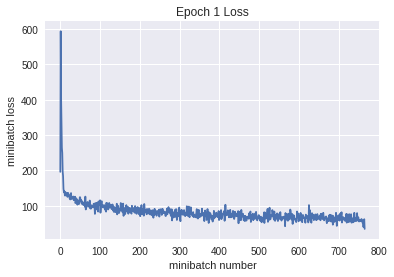

Iteration 800: with minibatch training loss = 0.987 and accuracy of 0.67
Iteration 900: with minibatch training loss = 0.714 and accuracy of 0.75
Iteration 1000: with minibatch training loss = 0.641 and accuracy of 0.75
Iteration 1100: with minibatch training loss = 1.08 and accuracy of 0.66
Iteration 1200: with minibatch training loss = 0.895 and accuracy of 0.64
Iteration 1300: with minibatch training loss = 0.957 and accuracy of 0.72
Iteration 1400: with minibatch training loss = 0.697 and accuracy of 0.78
Iteration 1500: with minibatch training loss = 0.788 and accuracy of 0.81
Epoch 2, Overall loss = 0.806 and accuracy of 0.72


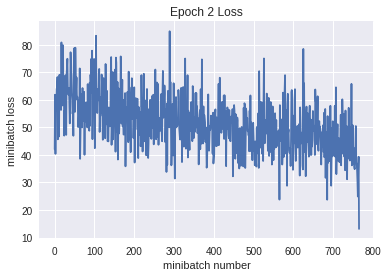

Iteration 1600: with minibatch training loss = 0.597 and accuracy of 0.75
Iteration 1700: with minibatch training loss = 0.554 and accuracy of 0.83
Iteration 1800: with minibatch training loss = 0.666 and accuracy of 0.72
Iteration 1900: with minibatch training loss = 0.457 and accuracy of 0.84
Iteration 2000: with minibatch training loss = 0.405 and accuracy of 0.88
Iteration 2100: with minibatch training loss = 0.37 and accuracy of 0.92
Iteration 2200: with minibatch training loss = 0.616 and accuracy of 0.81
Epoch 3, Overall loss = 0.554 and accuracy of 0.81


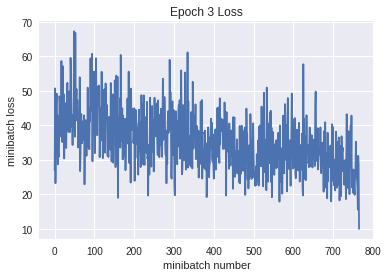

Iteration 2300: with minibatch training loss = 0.247 and accuracy of 0.91
Iteration 2400: with minibatch training loss = 0.501 and accuracy of 0.8
Iteration 2500: with minibatch training loss = 0.408 and accuracy of 0.88
Iteration 2600: with minibatch training loss = 0.24 and accuracy of 0.91
Iteration 2700: with minibatch training loss = 0.365 and accuracy of 0.89
Iteration 2800: with minibatch training loss = 0.308 and accuracy of 0.91
Iteration 2900: with minibatch training loss = 0.296 and accuracy of 0.89
Iteration 3000: with minibatch training loss = 0.312 and accuracy of 0.89
Epoch 4, Overall loss = 0.361 and accuracy of 0.878


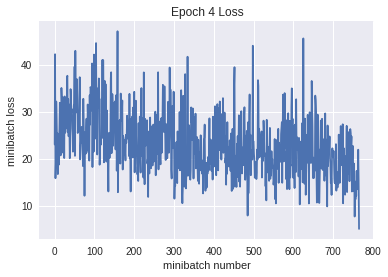

Iteration 3100: with minibatch training loss = 0.289 and accuracy of 0.89
Iteration 3200: with minibatch training loss = 0.374 and accuracy of 0.88
Iteration 3300: with minibatch training loss = 0.251 and accuracy of 0.91
Iteration 3400: with minibatch training loss = 0.182 and accuracy of 0.94
Iteration 3500: with minibatch training loss = 0.238 and accuracy of 0.94
Iteration 3600: with minibatch training loss = 0.225 and accuracy of 0.91
Iteration 3700: with minibatch training loss = 0.282 and accuracy of 0.91
Iteration 3800: with minibatch training loss = 0.284 and accuracy of 0.88
Epoch 5, Overall loss = 0.252 and accuracy of 0.913


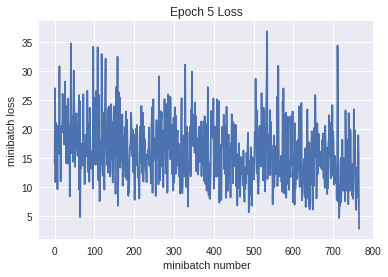

Iteration 3900: with minibatch training loss = 0.149 and accuracy of 0.97
Iteration 4000: with minibatch training loss = 0.221 and accuracy of 0.91
Iteration 4100: with minibatch training loss = 0.297 and accuracy of 0.89
Iteration 4200: with minibatch training loss = 0.274 and accuracy of 0.89
Iteration 4300: with minibatch training loss = 0.171 and accuracy of 0.94
Iteration 4400: with minibatch training loss = 0.268 and accuracy of 0.89
Iteration 4500: with minibatch training loss = 0.145 and accuracy of 0.98
Epoch 6, Overall loss = 0.169 and accuracy of 0.942


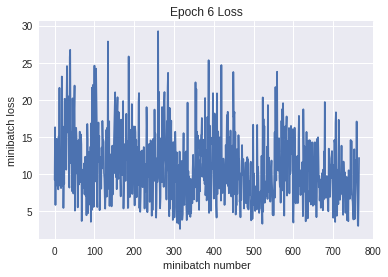

Iteration 4600: with minibatch training loss = 0.102 and accuracy of 0.97
Iteration 4700: with minibatch training loss = 0.289 and accuracy of 0.91
Iteration 4800: with minibatch training loss = 0.0566 and accuracy of 0.98
Iteration 4900: with minibatch training loss = 0.161 and accuracy of 0.92
Iteration 5000: with minibatch training loss = 0.0777 and accuracy of 0.97
Iteration 5100: with minibatch training loss = 0.133 and accuracy of 0.94
Iteration 5200: with minibatch training loss = 0.155 and accuracy of 0.94
Iteration 5300: with minibatch training loss = 0.111 and accuracy of 0.98
Epoch 7, Overall loss = 0.118 and accuracy of 0.96


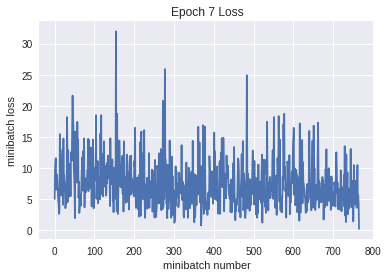

Iteration 5400: with minibatch training loss = 0.0509 and accuracy of 0.98
Iteration 5500: with minibatch training loss = 0.107 and accuracy of 0.95
Iteration 5600: with minibatch training loss = 0.162 and accuracy of 0.92
Iteration 5700: with minibatch training loss = 0.07 and accuracy of 0.97
Iteration 5800: with minibatch training loss = 0.0586 and accuracy of 0.98
Iteration 5900: with minibatch training loss = 0.205 and accuracy of 0.92
Iteration 6000: with minibatch training loss = 0.121 and accuracy of 0.97
Iteration 6100: with minibatch training loss = 0.166 and accuracy of 0.95
Epoch 8, Overall loss = 0.0955 and accuracy of 0.967


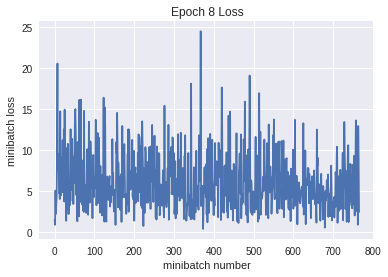

Iteration 6200: with minibatch training loss = 0.05 and accuracy of 0.98
Iteration 6300: with minibatch training loss = 0.145 and accuracy of 0.97
Iteration 6400: with minibatch training loss = 0.0318 and accuracy of 1
Iteration 6500: with minibatch training loss = 0.0509 and accuracy of 0.98
Iteration 6600: with minibatch training loss = 0.109 and accuracy of 0.97
Iteration 6700: with minibatch training loss = 0.0127 and accuracy of 1
Iteration 6800: with minibatch training loss = 0.0202 and accuracy of 1
Epoch 9, Overall loss = 0.0776 and accuracy of 0.974


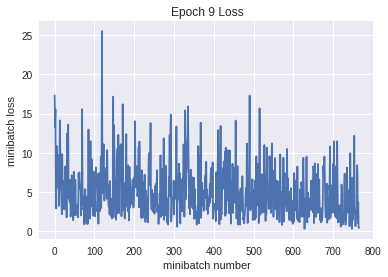

Iteration 6900: with minibatch training loss = 0.0295 and accuracy of 1
Iteration 7000: with minibatch training loss = 0.0616 and accuracy of 0.97
Iteration 7100: with minibatch training loss = 0.0467 and accuracy of 0.97
Iteration 7200: with minibatch training loss = 0.0243 and accuracy of 1
Iteration 7300: with minibatch training loss = 0.0823 and accuracy of 0.98
Iteration 7400: with minibatch training loss = 0.0518 and accuracy of 0.97
Iteration 7500: with minibatch training loss = 0.00451 and accuracy of 1
Iteration 7600: with minibatch training loss = 0.165 and accuracy of 0.94
Epoch 10, Overall loss = 0.0645 and accuracy of 0.979


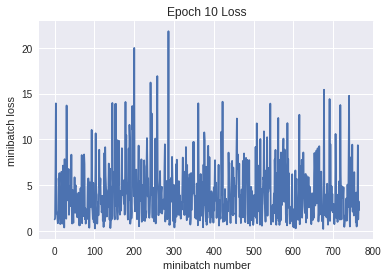

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.728


(1.606044951438904, 0.728)

In [55]:
# Sinta-se livre para modificar (e 'brincar') com o conteúdo desta célula

# Este código padrão, cria uma sessão e treina seu modelo por 10 épocas
# imprimindo ao final a acurácia sobre o conjunto de validação
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Agora, você deve usar a célula abaixo para avaliar a acurácia sobre os conjunto de treinamento e validação da rede final (aquela que lhe deixou mais satisfeito). 

In [56]:
# Por fim, você deve testar seu modelo aqui, se assegure de que 
# a saída desta célula seja a acurácia obtida pelo seu melhor
# modelo sobre os conjunto de treinamento e de validação.

# Você deve tentar alcançar algo em torno de 70% de acurácia
# sobre os dados de validação
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.0905 and accuracy of 0.97
Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.728


(1.6060449237823486, 0.728)



---



### Descreva o que você fez
Na próxima célula, você deve fornecer uma explicação sobre o que foi feito, além de descrever qualquer implementação adicional que tenha sido realizada, bem como visualizações e gráficos construídos ao longo do processo de treinamente e avaliação de sua rede. 

#### Arquitetura da Rede

Para construção da rede neural foi utilizada a mesma arquitetura da seção "Treinando um modelo mais complexo". Para adicionar desempenho a rede, foi repetida a mesma sequencia de camadas 4 vezes (indicados pelo comentário "trecho X" no código). 

A sequencia de camadas que se repetiu 4 vezes foi a seguinte:
  - convolução
  - relu
  - normalização
  - maxpool

Cada uma dessas sequencias de camada buscou aplicar filtros de 5x5 na convolução. Em seguida, as operações de relu e normalização foram aplicadas para os resultados da convolução. Por fim, uma operação de max pooling foi feita, reduzindo a dimensionalidade.

Da mesma forma que na seção usada como referência, foi aplicado uma trecho com as operações reshape+affine+relu, e, por fim, um último trecho com uma operação affine.

#### Justificativa

Para que a rede ficasse profunda, optei por repetir as mesmas camadas 4 vezes, de forma a aumentar a capacidade de representação. A partir de 3 camadas, a rede já apresentou bons resultados nos treinamentos. Decidi então adicionar uma nova camada, a fim de melhorar um pouco o resultado. O resultado não melhorou consideravelmente, indicando que a quarta camada parece não ser necessária. No entanto, resolvi mante-la.


#### Avaliação dos gráficos e resultados

No treinamento é possível ver que o primeiro resultado apresenta uma perda de até 600 unidades, caindo vertiginosamente logo após os primeiros minibatches. Nos gráficos seguintes, o valor máximo de perda diminui pouco a pouco (com flutuações). No gráfico 2, a perda média fica em 0.8, enquanto que no último gráfico (10), a perda fica em 0.06, com acurácia de 0.98. 

O último gráfico, inclusive, indica que a rede provavelmente já está próxima ao overtraining, quando passa a aprender os dados, ao invés de ser capaz de aprender características genéricas.

No resultado de validação, a acurácia cai para 0.728, bem inferior a acurácia obtida no treinamento, e bem próxima à segunda época. A perda fica na ordem de 1.61, maior inclusive que a primeira época de treinamento.


---



### Usando o conjunto de teste - Faça isto apenas uma única vez

Agora, que você obteve um resultado que considerou satisfatório, você deve avaliar seu modelo final sobre o conjunto de dados de teste. A performance obtida agora é a que seria alcançada em uma competição, por exemplo. Pense sobre como o seu resultado se comporta quando comparado com a acurária sobre o conjunto de dados de validação.

In [57]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.62 and accuracy of 0.716


(1.6236044883728027, 0.7158)